In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import threadpoolctl

import pandas as pd
import numpy as np
import re

import snowballstemmer as sn

!pip install wordcloud
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt


In [2]:
# numerik karakterlerin kaldırılması
def remove_numeric(value):
    bfr = [item for item in value if not item.isdigit()]
    return ''.join(bfr)
    
# emojilerin kaldırılması
def remove_emoji(value):
    bfr=re.compile("[\U00010000-\U0010ffff]",flags=re.UNICODE)
    bfr=bfr.sub(r'',value)
    return bfr

#noktalama işaretlerinin kaldırılması
def remove_noktalama(value):
    return re.sub(r'[^\w\s]','',value)

#tek karakterli ifadelerin kaldırılması
def remove_single_chracter(value):
    return re.sub(r'(?:^|\s)\w(?:$|\s)', '', value)
    
    
#linklerin kaldırılması 
def remove_link(value):
    return re.sub('((www\.[^\s]+)|(https?//[^\s]+))','',value)

# hashtaglerin kaldırılması
def remove_hashtag(value):
    return re.sub(r'#[^\s]+','',value)
    

# kullanıcı adlarının kaldırılması
def remove_username(value):
    return re.sub('@[^\s]+','',value)


#kök indirgeme ve stop words işlemleri
def stem_word(value):
    stemmer = sn.stemmer("turkish")
    value=value.lower()
    value = stemmer.stemWords(value.split())
    stop_words=['acaba', 'ama', 'aslinda', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu',
'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep', 'hepsi', 'her', 'hic', 'için', 'ile', 'ise', 'kez', 'ki', 'kim', 'mi', 'mu', 'mü', 'nasil', 'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin', 'niye', 'o', 'sanki', 'şey', 'siz', 'su',
'tüm', 've', 'veya', 'ya', 'yani', 'bir', 'iki', 'üç', 'dört', 'beş', 'altı', 'yedi', 'sekiz', 'dokuz', 'on'] 
    value= [item for item in value if not item in stop_words]
    value=''.join(value)
    return value
    
# ön işlem fonksiyonlarının sırayla çağırılması   
def pre_processing (value):
    return [remove_numeric(remove_emoji
            (remove_noktalama
             (remove_single_chracter
              (remove_link
               (remove_hashtag
                (remove_username
                 (stem_word(word)))))))) for word in value.split()]

# Boşlukların kaldırılması
def remove_space(value):
    return [item for item in value if item.strip()]


In [3]:
df =pd.read_csv("data/nlp_proje_metin_siniflandirma.csv",index_col=0)
df

,Text,Label
0,turkcellmüzik biraz daha gelişsin fizy yi tama...,1
1,hayat paylaşınca güzel...türkcell...,1
2,superonline varya daha iyi,1
3,hahaha kanka turkcell bu 4 ceker :d,1
4,turkcell 3 tl hediye etse bana ne güzel olur =),1
...,...,...
2995,gördüğüm en adi şerefsiz kurumsunuz,2
2996,#turkcell seni de ben boykot edicem.,2
2997,diğer hatların çekmediği yerde çeken her hattı...,2
2998,"sanirim 3g baglanti sorunu var, surekli edge o...",2


In [7]:
#null değerleri silme
df = df.dropna()
df

,Text,Label,Text_2,Text_3
0,turkcellmüzik biraz daha gelişsin fizy yi tama...,1,"[turkcellmüzik, biraz, dah, geliş, fizy, yi, t...",turkcellmüzik biraz dah geliş fizy yi tamame b...
1,hayat paylaşınca güzel...türkcell...,1,"[hayat, paylaş, güzeltürkcell]",hayat paylaş güzeltürkcell
2,superonline varya daha iyi,1,"[superonl, varya, dah]",superonl varya dah
3,hahaha kanka turkcell bu 4 ceker :d,1,"[hahah, kanka, turkcell, ceker, d]",hahah kanka turkcell ceker d
4,turkcell 3 tl hediye etse bana ne güzel olur =),1,"[turkcell, tl, hedi, et, ba, güzel, olur]",turkcell tl hedi et ba güzel olur
...,...,...,...,...
2993,gördüğüm en adi şerefsiz kurumsunuz,2,"[gördük, adi, şerefsiz, kur]",gördük adi şerefsiz kur
2994,#turkcell seni de ben boykot edicem.,2,"[se, ben, boykot, edicem]",se ben boykot edicem
2995,diğer hatların çekmediği yerde çeken her hattı...,2,"[diğer, hat, çekmedik, yer, çeke, hat, çektik,...",diğer hat çekmedik yer çeke hat çektik yer çek...
2996,"sanirim 3g baglanti sorunu var, surekli edge o...",2,"[sanir, g, baglanti, sor, var, surekli, edge, ...",sanir g baglanti sor var surekli edge oluyor i...


In [8]:
df["Text_2"] = df["Text"].apply(pre_processing)
df["Text_2"] = df["Text_2"].apply(remove_space)
df["Text_3"] = [" ".join(wrd for wrd in x) for x in df["Text_2"]]

df_index = df[df["Text_2"].str[0].isnull()].index
df = df.drop(df_index)
df = df.reset_index()
del df["index"]
df.head()

,Text,Label,Text_2,Text_3
0,turkcellmüzik biraz daha gelişsin fizy yi tama...,1,"[turkcellmüzik, biraz, dah, geliş, fizy, yi, t...",turkcellmüzik biraz dah geliş fizy yi tamame b...
1,hayat paylaşınca güzel...türkcell...,1,"[hayat, paylaş, güzeltürkcell]",hayat paylaş güzeltürkcell
2,superonline varya daha iyi,1,"[superonl, varya, dah]",superonl varya dah
3,hahaha kanka turkcell bu 4 ceker :d,1,"[hahah, kanka, turkcell, ceker, d]",hahah kanka turkcell ceker d
4,turkcell 3 tl hediye etse bana ne güzel olur =),1,"[turkcell, tl, hedi, et, ba, güzel, olur]",turkcell tl hedi et ba güzel olur


In [9]:
df.groupby("Label").size()

Label
1     756
2    1286
3     956
dtype: int64

In [11]:
df_test= pd.DataFrame({"text":msg_test,'label':label_test})
df_test.groupby("label").size()

NameError: name 'msg_test' is not defined

In [12]:
df["Label"] = df["Label"].astype("str")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2998 non-null   object
 1   Label   2998 non-null   object
 2   Text_2  2998 non-null   object
 3   Text_3  2998 non-null   object
dtypes: object(4)
memory usage: 93.8+ KB


In [13]:
df["Label2"] = df["Label"].replace("1","pozitif")
df["Label2"] = df["Label2"].replace("2","negatif")
df["Label2"] = df["Label2"].replace("3","nötr")
df.head()

,Text,Label,Text_2,Text_3,Label2
0,turkcellmüzik biraz daha gelişsin fizy yi tama...,1,"[turkcellmüzik, biraz, dah, geliş, fizy, yi, t...",turkcellmüzik biraz dah geliş fizy yi tamame b...,pozitif
1,hayat paylaşınca güzel...türkcell...,1,"[hayat, paylaş, güzeltürkcell]",hayat paylaş güzeltürkcell,pozitif
2,superonline varya daha iyi,1,"[superonl, varya, dah]",superonl varya dah,pozitif
3,hahaha kanka turkcell bu 4 ceker :d,1,"[hahah, kanka, turkcell, ceker, d]",hahah kanka turkcell ceker d,pozitif
4,turkcell 3 tl hediye etse bana ne güzel olur =),1,"[turkcell, tl, hedi, et, ba, güzel, olur]",turkcell tl hedi et ba güzel olur,pozitif


In [14]:
Vectorizer = CountVectorizer()
A = Vectorizer.fit_transform(df["Text_3"].tolist())


In [15]:
df["Text_4"] = A.toarray().tolist()
df.head()

,Text,Label,Text_2,Text_3,Label2,Text_4
0,turkcellmüzik biraz daha gelişsin fizy yi tama...,1,"[turkcellmüzik, biraz, dah, geliş, fizy, yi, t...",turkcellmüzik biraz dah geliş fizy yi tamame b...,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,hayat paylaşınca güzel...türkcell...,1,"[hayat, paylaş, güzeltürkcell]",hayat paylaş güzeltürkcell,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,superonline varya daha iyi,1,"[superonl, varya, dah]",superonl varya dah,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,hahaha kanka turkcell bu 4 ceker :d,1,"[hahah, kanka, turkcell, ceker, d]",hahah kanka turkcell ceker d,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,turkcell 3 tl hediye etse bana ne güzel olur =),1,"[turkcell, tl, hedi, et, ba, güzel, olur]",turkcell tl hedi et ba güzel olur,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
#TF-IDF
Vectorizer = TfidfVectorizer()
A = Vectorizer.fit_transform(df["Text_3"].tolist())
print(A.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
set(A.toarray()[0])
df["Text_5"] = A.toarray().tolist()
df.head()

,Text,Label,Text_2,Text_3,Label2,Text_4,Text_5
0,turkcellmüzik biraz daha gelişsin fizy yi tama...,1,"[turkcellmüzik, biraz, dah, geliş, fizy, yi, t...",turkcellmüzik biraz dah geliş fizy yi tamame b...,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,hayat paylaşınca güzel...türkcell...,1,"[hayat, paylaş, güzeltürkcell]",hayat paylaş güzeltürkcell,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,superonline varya daha iyi,1,"[superonl, varya, dah]",superonl varya dah,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,hahaha kanka turkcell bu 4 ceker :d,1,"[hahah, kanka, turkcell, ceker, d]",hahah kanka turkcell ceker d,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,turkcell 3 tl hediye etse bana ne güzel olur =),1,"[turkcell, tl, hedi, et, ba, güzel, olur]",turkcell tl hedi et ba güzel olur,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
model = Word2Vec(sentences = df["Text_2"].tolist(), vector_size=100, window=5, min_count=1)
model.save("data/word2vec.model")
print(model)

Word2Vec<vocab=9052, vector_size=100, alpha=0.025>


In [19]:
words = list(model.wv.index_to_key)
len(words)

9052

In [20]:
def word2vec_analysis(value):
    model = Word2Vec.load("data/word2vec.model")
    bfr_list = []
    bfr_len = len(value)
    for k in value:
        bfr=model.wv.key_to_index[k]
        bfr=model.wv[bfr]
        bfr_list.append(bfr)
    bfr_list = sum(bfr_list)
    bfr_list=bfr_list/bfr_len 
    return bfr_list.tolist()
    bfr_list = []
    bfr_len = len(value)
    for k in value:
        bfr=model.wv.key_to_index[k]
        bfr=model.wv[bfr]
        bfr_list.append(bfr)
    bfr_list = sum(bfr_list)
    bfr_list=bfr_list/bfr_len 
    return bfr_list.tolist()

In [21]:
df["word2vec"] = df["Text_2"].apply(word2vec_analysis)
df.head()

,Text,Label,Text_2,Text_3,Label2,Text_4,Text_5,word2vec
0,turkcellmüzik biraz daha gelişsin fizy yi tama...,1,"[turkcellmüzik, biraz, dah, geliş, fizy, yi, t...",turkcellmüzik biraz dah geliş fizy yi tamame b...,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005212465766817331, 0.012301879934966564, ..."
1,hayat paylaşınca güzel...türkcell...,1,"[hayat, paylaş, güzeltürkcell]",hayat paylaş güzeltürkcell,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.025849664583802223, 0.040317993611097336, ..."
2,superonline varya daha iyi,1,"[superonl, varya, dah]",superonl varya dah,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.012317893095314503, 0.047111134976148605, ..."
3,hahaha kanka turkcell bu 4 ceker :d,1,"[hahah, kanka, turkcell, ceker, d]",hahah kanka turkcell ceker d,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02038310095667839, 0.0563603937625885, 0.0..."
4,turkcell 3 tl hediye etse bana ne güzel olur =),1,"[turkcell, tl, hedi, et, ba, güzel, olur]",turkcell tl hedi et ba güzel olur,pozitif,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.020607037469744682, 0.06880451738834381, 0..."


In [88]:
svm= Pipeline([('vect',TfidfVectorizer()),('svm',LinearSVC())])

In [89]:
msg_train, msg_test, label_train, label_test = train_test_split(df["Text_3"].tolist(), df["Label"].tolist(), test_size=0.2, random_state=42)

In [90]:
knn = Pipeline([("vect",TfidfVectorizer()),("knn",KNeighborsClassifier())])
knn.fit(msg_train,label_train)
yPredClass = knn.predict(msg_test)

print("KNN Accuracy(TF-IDF):", accuracy_score(label_test,yPredClass))
print("KNN F1-Score(TF-IDF):", f1_score(label_test,yPredClass,average="weighted"))


KNN Accuracy(TF-IDF): 0.7875
KNN F1-Score(TF-IDF): 0.7873621626434038


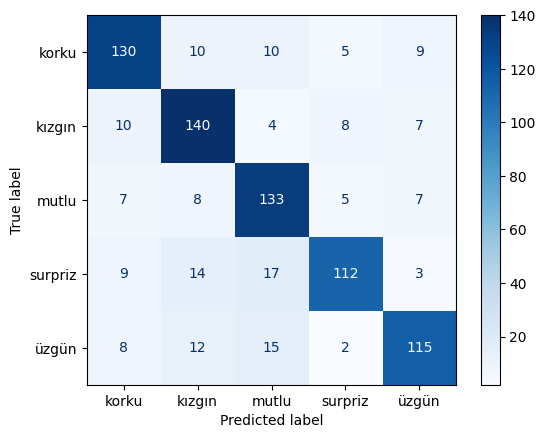

In [91]:
cm = confusion_matrix(label_test, yPredClass, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')

In [92]:
msg_train, msg_test, label_train, label_test = train_test_split(df["word2vec"].tolist(), df["Label"].tolist(), test_size=0.2, random_state=42)
knn = Pipeline([('knn',KNeighborsClassifier())])
knn.fit(msg_train,label_train)
yPredClass = knn.predict(msg_test)

print("KNN Accuracy(word2vec):", accuracy_score(label_test,yPredClass))
print("KNN F1-Score(word2vec):", f1_score(label_test,yPredClass,average="weighted"))

KNN Accuracy(word2vec): 0.36
KNN F1-Score(word2vec): 0.35002100707707323


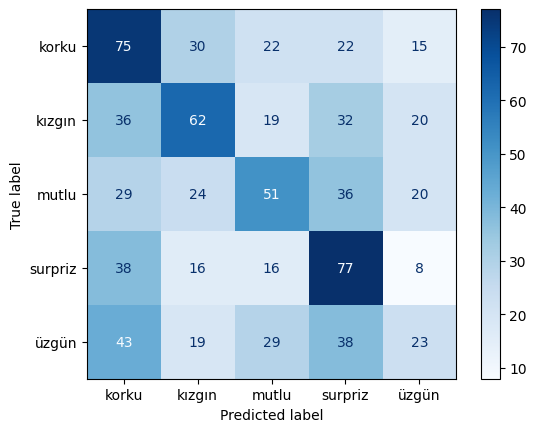

In [93]:
cm = confusion_matrix(label_test, yPredClass, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')

In [97]:
arr=np.empty((0,100),dtype='f')
arr

array([], shape=(0, 100), dtype=float32)

In [98]:
#2- Metin Görselleştirme (3. sayfa)
#Adım-1 : Veri kümesini ön işlem adımlarından geçirip, Word2vec ile modeli eğitiniz. Ardından bir kelime
#seçmeniz ve bu kelimeye en yakın 10 kelimeyi seçerek TSNE algoritması kullanarak görselleştirip
#anlatmanız beklenmektedir.
model = Word2Vec.load("data/word2vec.model")
words=list(model.wv.index_to_key)
df_name=[]
df_count=[]

for i in words:
    df_name.append(i)
    df_count.append(model.wv.get_vecattr(i,"count"))

df=pd.DataFrame({"name":df_name,"count":df_count})
df.head(10)

,name,count
0,turkcell,1556
1,mesaj,278
2,be,275
3,bi,209
4,am,207
5,d,207
6,güzel,204
7,var,200
8,hayat,197
9,ben,184


In [100]:
word="hayat"
word_labels=[word]
word_labels

close_words=model.wv.most_similar([word])
close_words


[('güzel', 0.986538290977478),
 ('paylaş', 0.974303662776947),
 ('be', 0.9645558595657349),
 ('ol', 0.9640970230102539),
 ('iş', 0.9636733531951904),
 ('iç', 0.9616185426712036),
 ('hal', 0.9607723951339722),
 ('am', 0.9606976509094238),
 ('cok', 0.9606961011886597),
 ('nasıl', 0.9606372117996216)]

In [101]:
word_labels

['hayat']

In [102]:
arr=np.append(arr,np.array([model.wv.get_vector(word)]),axis=0)
arr

array([[-0.05162445,  0.05980908,  0.04872431,  0.00999912,  0.01373733,
        -0.0963954 ,  0.04852499,  0.1544159 , -0.07234328, -0.02570864,
        -0.03531275, -0.13805024,  0.02440413,  0.01516029,  0.00370336,
        -0.05513408,  0.01648556, -0.072689  , -0.00146451, -0.17392759,
         0.04006713,  0.03558092,  0.08217536, -0.03449874,  0.01401095,
         0.01349483, -0.04814721, -0.07490168, -0.07170943, -0.02548546,
         0.05074594,  0.02607232,  0.06528328, -0.03066299, -0.05725128,
         0.06171818, -0.00212233, -0.04715451, -0.05877586, -0.17224029,
         0.00791471, -0.03979513, -0.02070537,  0.01651576,  0.04806913,
        -0.06497143, -0.08021701, -0.01241561,  0.00099273,  0.04439187,
         0.01313615, -0.07231045, -0.04780472, -0.02911466, -0.00696795,
        -0.03476459,  0.05467035, -0.00805803, -0.04662738,  0.02512615,
        -0.02639594, -0.0157556 ,  0.03818942,  0.00507562, -0.10323624,
         0.07184742,  0.00535989,  0.06142863, -0.1

In [103]:
for word_score in close_words:
    wrd_vector=model.wv.get_vector(word_score[0])
    word_labels.append(word_score[0])
    arr=np.append(arr,np.array([wrd_vector]),axis=0)

In [104]:
arr

array([[-0.05162445,  0.05980908,  0.04872431, ..., -0.0160006 ,
         0.06453754, -0.02770704],
       [-0.03278493,  0.047131  ,  0.0478517 , ..., -0.03470745,
         0.06199536, -0.01677788],
       [-0.03821667,  0.03092768,  0.05623259, ..., -0.00849347,
         0.06629093, -0.0084421 ],
       ...,
       [-0.05393097,  0.07710815,  0.03633587, ..., -0.05795805,
         0.06145348, -0.02793858],
       [-0.03739253,  0.0461866 ,  0.01998309, ..., -0.03951807,
         0.04530355, -0.01669591],
       [-0.01601994,  0.03362492,  0.01832569, ..., -0.02836548,
         0.02383167, -0.00657032]], dtype=float32)

In [105]:
len(arr)

11

In [106]:
from sklearn.manifold import TSNE


In [107]:
tsne= TSNE(n_components=2,random_state=42, perplexity=10)
np.printoptions(suppress=True)
Y = tsne.fit_transform(arr)

In [108]:
Y

array([[-32.868927 , -71.6213   ],
       [ 78.102715 ,  31.660143 ],
       [-89.26755  , -35.642925 ],
       [ 82.0186   , -34.521618 ],
       [ 13.961267 ,  31.888895 ],
       [ 18.843353 , -26.711226 ],
       [-33.33351  ,  76.9691   ],
       [-35.771084 ,  -0.6386494],
       [ 36.243736 ,  90.72688  ],
       [ 32.833477 , -88.71214  ],
       [-86.960846 ,  37.38922  ]], dtype=float32)

In [109]:
x_cords=Y[:,0]
x_cords

array([-32.868927,  78.102715, -89.26755 ,  82.0186  ,  13.961267,
        18.843353, -33.33351 , -35.771084,  36.243736,  32.833477,
       -86.960846], dtype=float32)

In [110]:
y_cords=Y[:,1]
y_cords

array([-71.6213   ,  31.660143 , -35.642925 , -34.521618 ,  31.888895 ,
       -26.711226 ,  76.9691   ,  -0.6386494,  90.72688  , -88.71214  ,
        37.38922  ], dtype=float32)

In [111]:
word_labels

['hayat',
 'güzel',
 'paylaş',
 'be',
 'ol',
 'iş',
 'iç',
 'hal',
 'am',
 'cok',
 'nasıl']

In [112]:
import plotly.express as px

In [113]:
fig=px.scatter(x=x_cords.tolist(),y=y_cords.tolist(),text=word_labels,size_max=100)
fig.update_layout(height=800,title_text="Word2vec En Benzer 10 Kelime")
fig.show()
#adım1 sonu

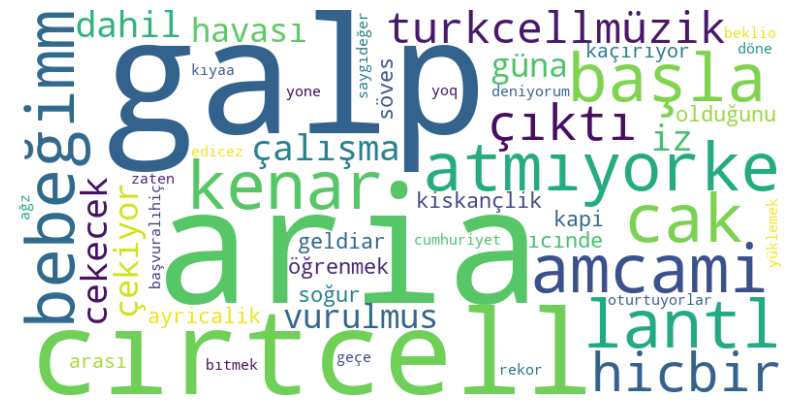

In [114]:
# Word2Vec modelini yükleme
model = Word2Vec.load("data/word2vec.model")

# En çok kullanılan 50 kelime
top_words = [word for word, _ in model.wv.most_similar(positive=['kelime'], topn=50)]

# WordCloud nesnesini oluşturma ve en çok kullanılan 50 kelimeyi kullanarak WordCloud'u oluşturma
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))

# WordCloud'u görselleştirme
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [115]:
print(model)

Word2Vec<vocab=9052, vector_size=100, alpha=0.025>
